<a href="https://colab.research.google.com/github/ddesai-sjsu/Machine-Learning/blob/main/Restaurant_rating_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Restaurant Rating Prediction:**


I have taken YELP Business data as dataset. Business data from yelp has details of business like latitude, longitude, rating, categories and attributes. Attributes in the data, define various characteristics of the business like price range, happy hours, parking facility, etc. 

I am using K-Means clustering method, to find if any of these attributes influence the overall rating of the business, which is actually cummulative rating given by the user.


1. Installing gdown to download data from google drive

In [2]:
!pip install gdown

In [3]:
  import gdown

  url = 'https://drive.google.com/uc?id=1Z0qP3bGH7sM4ExVoHJbHEeRl3tDiMohN'
  output = 'yelp.json'
  gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1Z0qP3bGH7sM4ExVoHJbHEeRl3tDiMohN
To: /content/yelp.json
124MB [00:01, 107MB/s]


'yelp.json'

2. Importing libraries and reading json data

In [4]:
import sqlite3
import pandas as pd
from pandas.io.json import json_normalize
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D

In [5]:
df=pd.read_json('/content/yelp.json',lines=True)
df['attributes'] = df['attributes'].apply(lambda x: {} if pd.isna(x) else x)
df2=json_normalize(df['attributes'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


3. Normalizing columns and data cleaning

In [6]:
df3 = pd.merge(df,df2,left_index=True,right_index=True)


In [7]:
df3=df3.drop('attributes',1)
df3=df3.drop('categories',1)
df3=df3.drop('hours',1)
df3=df3.drop('BusinessParking',1)
df3=df3.drop('Ambience',1)
df3=df3.drop('GoodForMeal',1)

In [8]:
df3.fillna(False,inplace=True)

In [9]:
df3['WiFi'].replace("u'no'", False, inplace=True)
df3['Alcohol'].replace(["u'beer_and_wine'","'beer_and_wine'"], True, inplace=True)
df3['NoiseLevel'].replace(["u'average'","'average'"	], True, inplace=True)



In [10]:
df3.replace('False', 0, inplace=True)
df3.replace('True', 1, inplace=True)
df3.replace(False, 0, inplace=True)
df3.replace(True, 1, inplace=True)
df3

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,RestaurantsTableService,WiFi,BikeParking,BusinessAcceptsCreditCards,RestaurantsReservations,WheelchairAccessible,Caters,OutdoorSeating,RestaurantsGoodForGroups,HappyHour,BusinessAcceptsBitcoin,RestaurantsPriceRange2,HasTV,Alcohol,DogsAllowed,RestaurantsTakeOut,NoiseLevel,RestaurantsAttire,RestaurantsDelivery,GoodForKids,ByAppointmentOnly,AcceptsInsurance,HairSpecializesIn,GoodForDancing,BestNights,Music,BYOB,CoatCheck,Smoking,DriveThru,BYOBCorkage,Corkage,RestaurantsCounterService,AgesAllowed,DietaryRestrictions,Open24Hours
0,6iYb2HFDywm3zjuRg0shjw,Oskar Blues Taproom,921 Pearl St,Boulder,CO,80302,40.017544,-105.283348,4.0,86,1,1,u'free',1,1,0,1,1,1,1,1,0,2,1,1,0,1,1,'casual',None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,tCbdrRPZA0oiIYSmHG3J0w,Flying Elephants at PDX,7000 NE Airport Way,Portland,OR,97218,45.588906,-122.593331,4.0,126,1,0,u'free',0,1,0,0,1,0,0,0,0,2,0,1,0,1,1,u'casual',0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,bvN78flM8NLprQ1a1y5dRg,The Reclaimory,4720 Hawthorne Ave,Portland,OR,97214,45.511907,-122.613693,4.5,13,1,0,0,0,1,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,oaepsyvc0J17qwi8cfrOWg,Great Clips,2566 Enterprise Rd,Orange City,FL,32763,28.914482,-81.295979,3.0,8,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,PE9uqAjdw0E4-8mjGl3wVA,Crossfit Terminus,1046 Memorial Dr SE,Atlanta,GA,30316,33.747027,-84.353424,4.0,14,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160580,D2mHoIDXx9N8mS1pGoKV9Q,Eleven Oaks Realty,,Austin,TX,78701,30.272921,-97.744386,4.0,8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
160581,bQX-kwVTyZgcdZGEPzce6Q,Webb's Honey,21777 State Rd 520,Orlando,FL,32833,28.499836,-81.047478,4.5,18,1,0,0,1,1,0,0,0,0,0,0,0,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
160582,wvFZ06nmPmQ2-IVoPqVYLA,Painting with a Twist,2164 S Chickasaw Trl,Orlando,FL,32825,28.511615,-81.270020,5.0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
160583,GB75wPibj3IjNauaoCxyGA,Havana Cafe,910 NW 14th St,Portland,OR,97209,45.529647,-122.685153,4.0,10,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [13]:
cols = df3.columns # Saving column names to a variable


In [14]:
cols=[
       'postal_code','review_count','stars','RestaurantsReservations',
       'WheelchairAccessible', 'Caters', 'OutdoorSeating',
       'RestaurantsGoodForGroups', 'HappyHour', 'BusinessAcceptsBitcoin',
       'RestaurantsPriceRange2', 'HasTV', 'Alcohol', 'DogsAllowed',
       'RestaurantsTakeOut', 'NoiseLevel', 'RestaurantsDelivery',
       'GoodForKids','business_id']

In [26]:
df4=df3[cols].apply(pd.to_numeric, errors='coerce') 
df4

,postal_code,review_count,stars,RestaurantsReservations,WheelchairAccessible,Caters,OutdoorSeating,RestaurantsGoodForGroups,HappyHour,BusinessAcceptsBitcoin,RestaurantsPriceRange2,HasTV,Alcohol,DogsAllowed,RestaurantsTakeOut,NoiseLevel,RestaurantsDelivery,GoodForKids,business_id
0,80302.0,86,4.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,2.0,1.0,1.0,0.0,1.0,1.0,NaN,0.0,NaN
1,97218.0,126,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,NaN
2,97214.0,13,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,32763.0,8,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN
4,30316.0,14,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160580,78701.0,8,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
160581,32833.0,18,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN
160582,32825.0,8,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN
160583,97209.0,10,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,NaN


4.  Plotting a heatmap using seaborn to find the relation between various attributes and ratings of the business

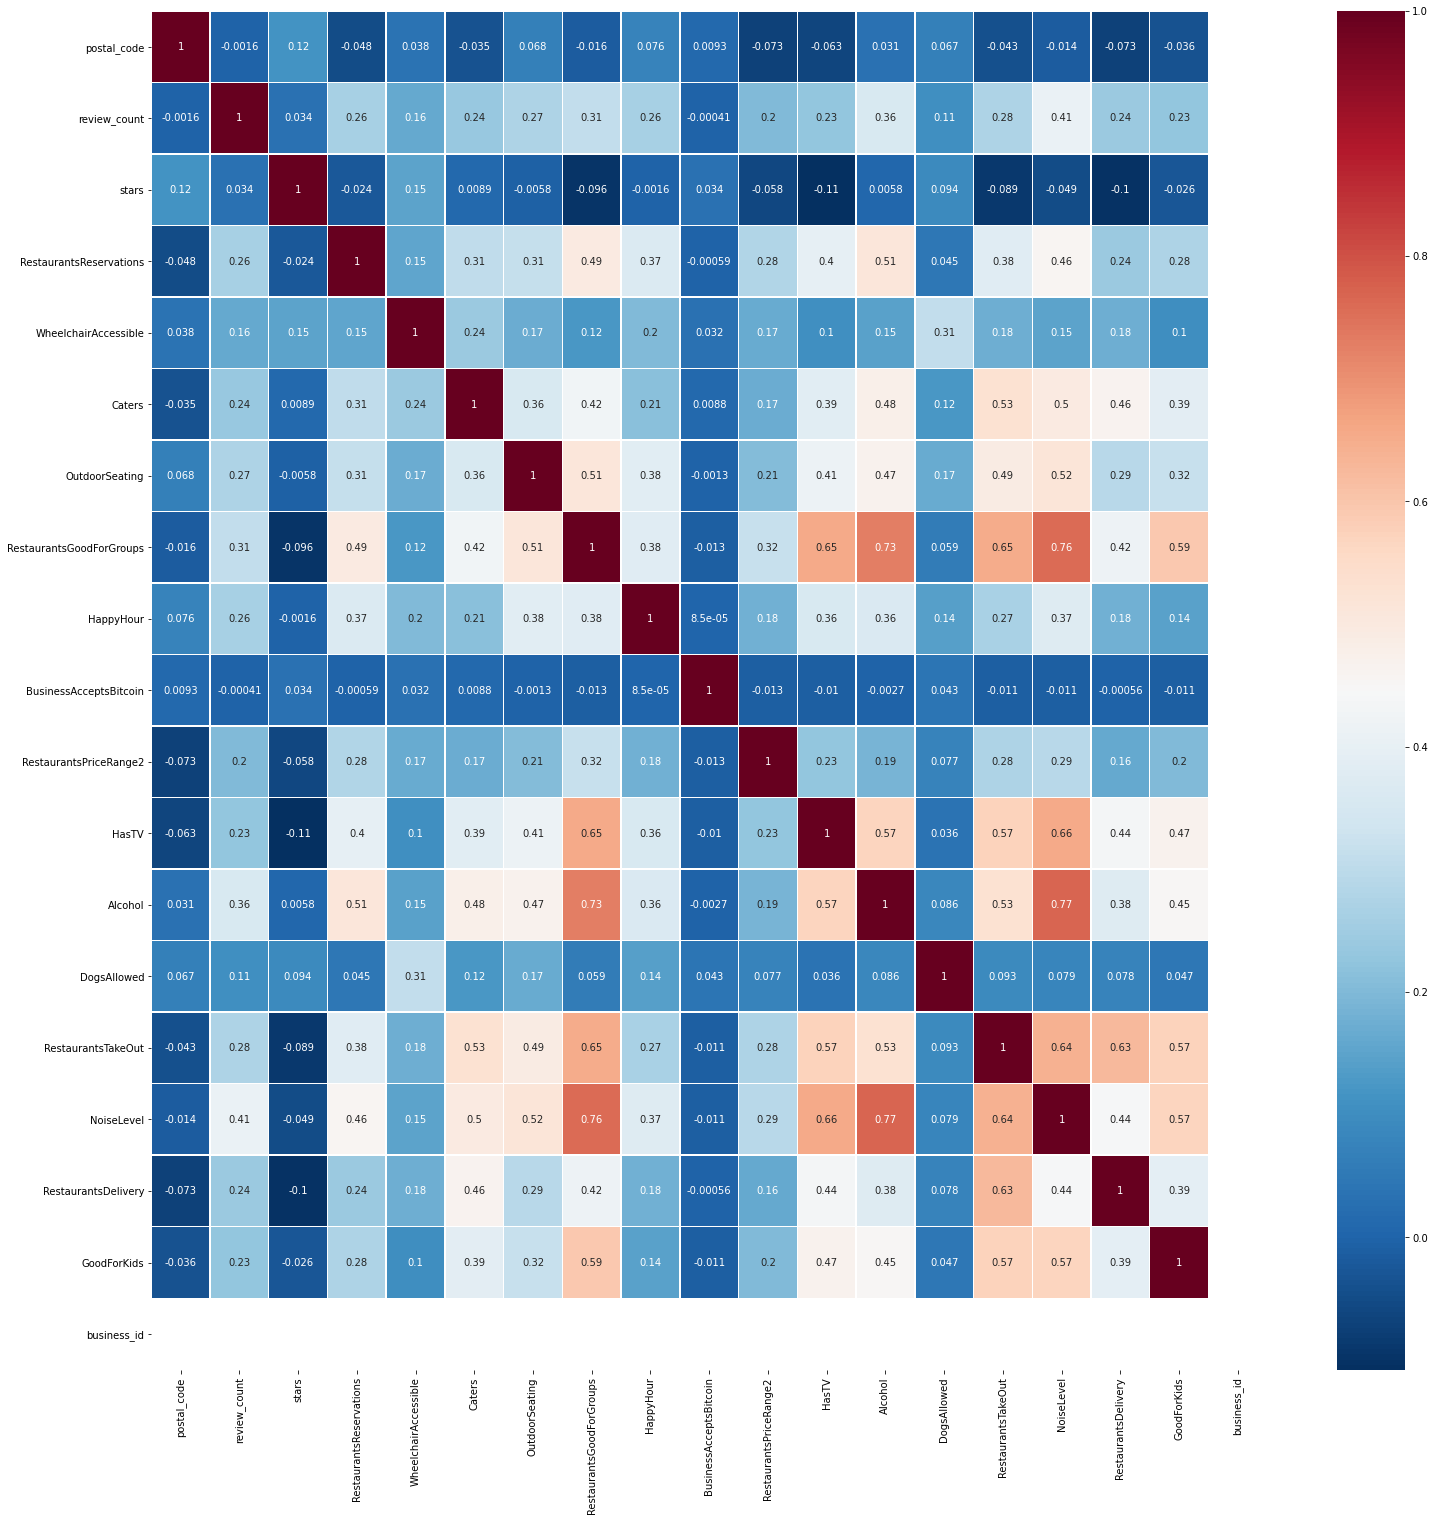

In [27]:

import seaborn as sb

pearsoncorr=df4.corr()
plt.figure(1,figsize=(25,25))
sb.heatmap(pearsoncorr, 
            xticklabels=pearsoncorr.columns,
            yticklabels=pearsoncorr.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.5)

In [37]:
df5=df4[['RestaurantsPriceRange2','stars']]
df5=df5.dropna()
df5

,RestaurantsPriceRange2,stars
0,2.0,4.0
1,2.0,4.0
2,2.0,4.5
3,1.0,3.0
4,0.0,4.0
...,...,...
160580,0.0,4.0
160581,2.0,4.5
160582,0.0,5.0
160583,0.0,4.0


5. Finding optimal k using elblow method
I also, plotted error versus number of clusters to select the appropriate number of clusters for kmeans. As shown in the below plot, since there is a sharp decline till 5 and then the error decreases slowly. Hence, I selected 5 clusters for clustering. 
As you can see from the below graph, optimal number of clusters is 5.

In [36]:
Sum_of_squared_distances = []
K = range(2,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df5)
    Sum_of_squared_distances.append(km.inertia_)

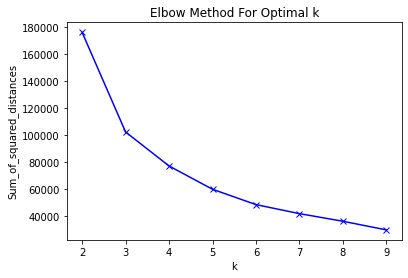

In [38]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

6. Visualized the clusters by plotting the rating & price range of the business


As you can see from the below plot, price range of the restaurant doesnt influence the rating of the restaurant. Expensive restaurants have got similar ratings to that of the budget friendly restaurants.

As most of the values are categorical(True/False, 0/1), clustering was not giving comprehensive information. 

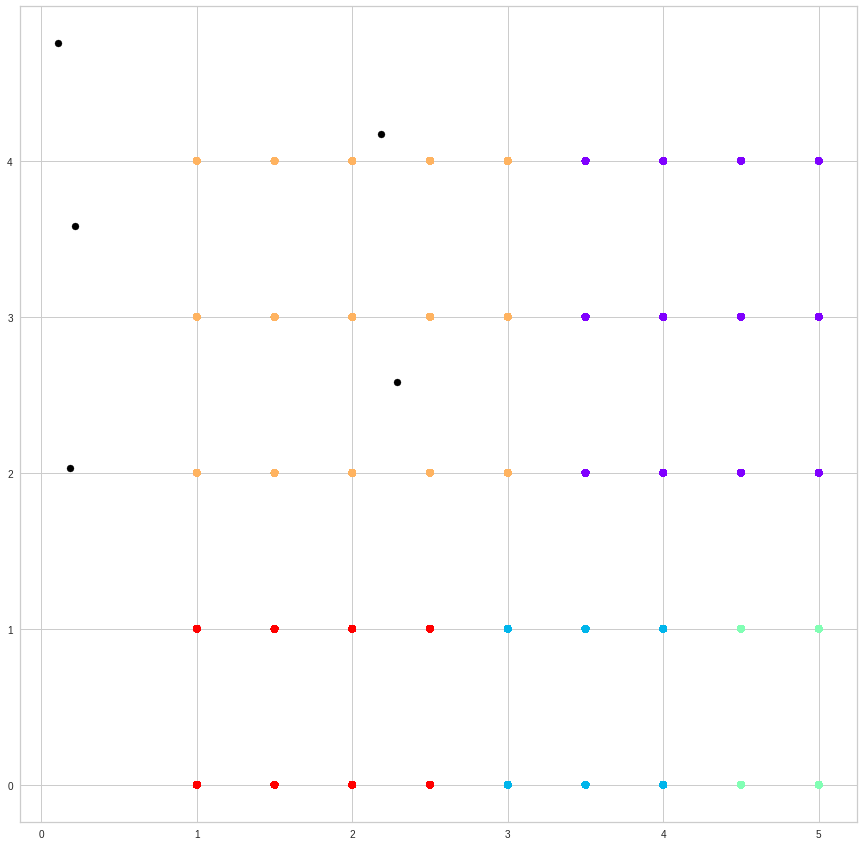

In [25]:
plt.figure(1,figsize=(15,15))
plt.scatter(df5.stars, df5.RestaurantsPriceRange2, c=kmeans.labels_, cmap='rainbow')
plt.scatter(kmeans.cluster_centers_[:,0] ,kmeans.cluster_centers_[:,1], color='black')

7.  Doing the same using tensorflow

In [41]:
import numpy as np
import tensorflow as tf

num_points = 100
dimensions = 2
# points = np.random.uniform(0, 1000, [num_points, dimensions])
points=df5
def input_fn():
    return tf.compat.v1.train.limit_epochs(
      tf.convert_to_tensor(points, dtype=tf.float32), num_epochs=1)

num_clusters = 5
kmeans = tf.compat.v1.estimator.experimental.KMeans(
    num_clusters=num_clusters, use_mini_batch=False)

# train
num_iterations = 10
previous_centers = None
for _ in range(num_iterations):
    kmeans.train(input_fn)
    cluster_centers = kmeans.cluster_centers()
    if previous_centers is not None:
        print('delta:', cluster_centers - previous_centers)
    previous_centers = cluster_centers
    print('score:', kmeans.score(input_fn))
print('cluster centers:', cluster_centers)

# map the input points to their clusters
cluster_indices = list(kmeans.predict_cluster_index(input_fn))
for i, point in enumerate(points):
    cluster_index = cluster_indices[i]
    center = cluster_centers[cluster_index]
    print('point:', point, 'is in cluster', cluster_indices, 'centered at', center)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpsvt6h4gt', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initiali

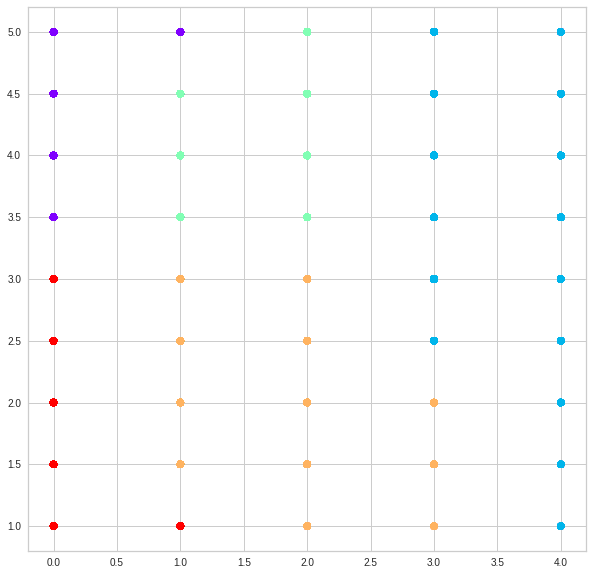

In [42]:
X=df5
k_means_predicted = kmeans.predict(X)
centroids = kmeans.cluster_centers
plt.figure('K-Means on Iris Dataset', figsize=(10,10),)
plt.scatter(X.RestaurantsPriceRange2 ,X.stars, c=cluster_indices, cmap='rainbow' )

In [72]:
new_df=df4.groupby(by=['postal_code','RestaurantsPriceRange2'],axis=0)['stars'].mean().reset_index()

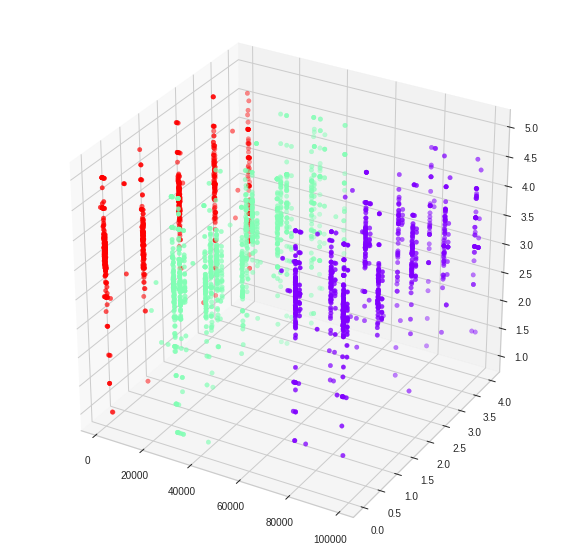

In [73]:
X=new_df
k_means = KMeans(n_clusters=3)
k_means.fit(X)
k_means_predicted = k_means.predict(X)
centroids = k_means.cluster_centers_
colors = ['navy', 'turquoise', 'darkorange']
plt.figure('K-Means on Iris Dataset', figsize=(10,10),)
ax = plt.axes(projection = '3d')
ax.scatter(X.postal_code,X.RestaurantsPriceRange2,X.stars, c=k_means.labels_, cmap='rainbow' )